# Análisis de constantes de filtrado


En esta notebook, haremos un análisis de las constantes para filtrar palabras y usuarios. En el trabajo original utilizamos 40 ocurrencias y 5 usuarios para filtrar, pero puede que no sea el mejor para este nuevo dataset.





In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from contrastes import read_occurrence_dataframe

df = read_occurrence_dataframe("../output/provinces_words.csv")

print("Total de palabras: {}".format(df.shape[0]))

Total de palabras: 2330112


/home/marat/projects/contrastes/notebooks/contrastes/processing.py:147: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.cant_palabras = cant_palabras
/home/marat/projects/contrastes/notebooks/contrastes/processing.py:148: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.cant_personas = cant_personas


Algunos ejemplos de palabras outsiders...

In [2]:
import hunspell
sc = hunspell.HunSpell("/usr/share/hunspell/es_AR.dic", "/usr/share/hunspell/es_AR.aff")
vocabulary = set()
accum = {}
m = 10

for i in range(1, 40):
    palabras = df[(df.cant_palabra >= (m* (i-1))) & (df.cant_palabra < (m * i))].index 
    cantidad = len(palabras)
    buenas = 0
    
    for w in palabras:
        try:
            if w in vocabulary or sc.spell(w):
                vocabulary.add(w)
                buenas+=1
        except:
            pass
            
    accum[m * i] = (cantidad - buenas) / cantidad


Text(0.5,0,'Cantidad de ocurrencias')

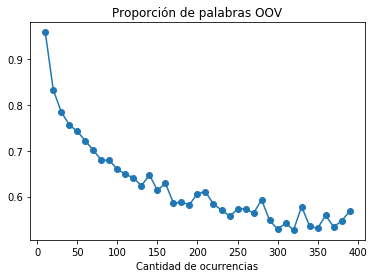

In [3]:
pd.Series(accum).plot(marker="o")

plt.title("Proporción de palabras OOV")
plt.xlabel("Cantidad de ocurrencias")

In [4]:
import hunspell
sc = hunspell.HunSpell("/usr/share/hunspell/es_AR.dic", "/usr/share/hunspell/es_AR.aff")
vocabulary = set()
accum = {}
m = 3

for i in range(1, 28):
    palabras = df[(df.cant_usuarios >= (m* (i-1))) & (df.cant_usuarios < (m * i))].index 
    cantidad = len(palabras)
    buenas = 0
    
    for w in palabras:
        try:
            if w in vocabulary or sc.spell(w):
                vocabulary.add(w)
                buenas+=1
        except:
            pass
            
    accum[m * i] = (cantidad - buenas) / cantidad


Text(0.5,0,'Cantidad de usuarios')

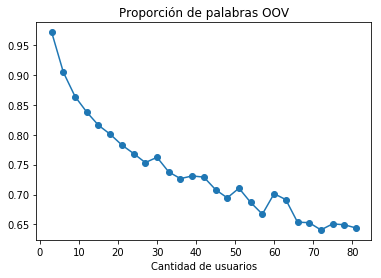

In [5]:
pd.Series(accum).plot(marker="o")

plt.title("Proporción de palabras OOV")
plt.xlabel("Cantidad de usuarios")

# Frecuencia acumulada 

Veamos primero la proporción de palabras del total que tienen menos que $5i$ apariciones

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

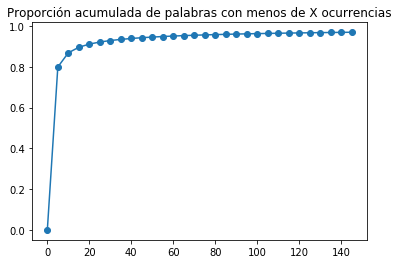

In [6]:
accum = { 0: 0 }

m = 5

for i in range(1, 30):
    accum[m * i] = len(df[df.cant_palabra < (m*i)]) / len(df)
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Viendo esto, como mínimo hay que eliminar las que tienen menos de 20 ocurrencias.

Veamos qué pasa con los usuarios...

Text(0.5,1,'Proporción acumulada de palabras con menos de X usuarios')

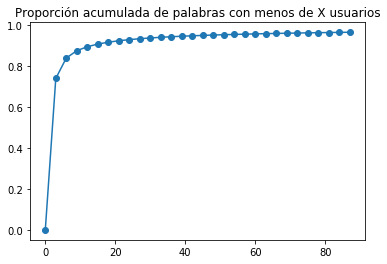

In [7]:
accum = { 0: 0 }

m = 3

for i in range(1, 30):
    accum[m * i] = len(df[df.cant_usuarios < (m*i)]) / len(df)
pd.Series(accum).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X usuarios")

## Usando la masa de ocurrencias

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

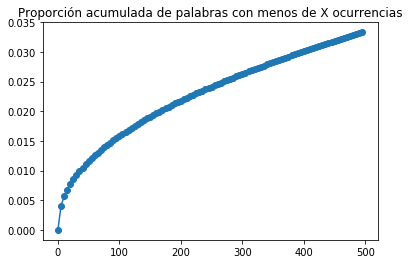

In [8]:


accum_palabras = { 0: 0 }

m = 5
total = df.cant_palabra.sum()

for i in range(1, 100):
    palabras = df[df.cant_palabra < (m*i)]
    accum_palabras[m * i] = palabras.cant_palabra.sum() / total
pd.Series(accum_palabras).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

Este gráfico puede echar un poco más de luz. Acá el crecimiento de la masa de ocurrencias se estabiliza alrededor de 100.

In [9]:
accum_palabras

{0: 0,
 5: 0.0040274794773785035,
 10: 0.005658827761977222,
 15: 0.0068073670824414295,
 20: 0.007745002981525996,
 25: 0.00853998491380537,
 30: 0.00925647286658085,
 35: 0.00989406515436282,
 40: 0.01049479198386302,
 45: 0.011063689873143582,
 50: 0.011591623567204081,
 55: 0.012098660346139307,
 60: 0.012582315939690397,
 65: 0.013047385854625709,
 70: 0.013485178234927588,
 75: 0.013919284378390129,
 80: 0.014329459336336593,
 85: 0.014733335556817013,
 90: 0.015123815566218678,
 95: 0.015500187145269613,
 100: 0.015876756477176974,
 105: 0.016225652768738053,
 110: 0.01657749835875944,
 115: 0.01691767962014,
 120: 0.017238320427394843,
 125: 0.017556616009367997,
 130: 0.01787039417452714,
 135: 0.018175287365644777,
 140: 0.018496359212328867,
 145: 0.018794003525303093,
 150: 0.019094485900755888,
 155: 0.01938058021095941,
 160: 0.019658586738323897,
 165: 0.019952104505364394,
 170: 0.020243871850636676,
 175: 0.020516114191225145,
 180: 0.020776701472837937,
 185: 0.021045

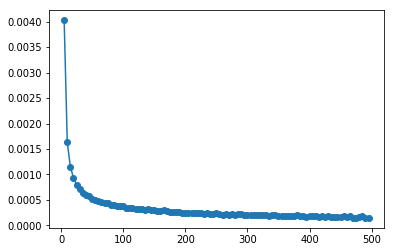

In [10]:
pd.Series(accum_palabras).diff().plot(marker='o')

Si bien es cierto que para N=40 hace que dejemos el 1% de la masa de las palabras, viendo la diferencia de crecimiento ésta parece estabilizarse para N=80. Prefiero quedarme con esto.

Corrección: nos quedamos con N=40 finalmente

Text(0.5,1,'Proporción acumulada de palabras con menos de X ocurrencias')

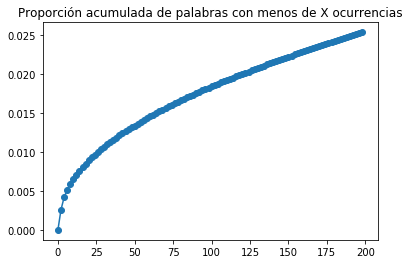

In [14]:


accum_personas = { 0: 0 }

m = 2
total = df.cant_palabra.sum()

for i in range(1, 100):
    palabras = df[df.cant_usuarios < (m*i)]
    accum_personas[m * i] = palabras.cant_palabra.sum() / total
pd.Series(accum_personas).plot(marker="o")

plt.title("Proporción acumulada de palabras con menos de X ocurrencias")

In [27]:
accum_personas

{0: 0,
 2: 0.002600420708078451,
 4: 0.004168523612336844,
 6: 0.005132513169428721,
 8: 0.005893194250783115,
 10: 0.006530996650975039,
 12: 0.007094255493959043,
 14: 0.0076067490157763085,
 16: 0.008078664578421222,
 18: 0.008512623952185633,
 20: 0.008925051438762339,
 22: 0.009315973302202584,
 24: 0.009682823390205385,
 26: 0.010028323894435002,
 28: 0.010351929449592064,
 30: 0.010671139638526193,
 32: 0.010987144068264336,
 34: 0.01129754807531069,
 36: 0.011586015419791339,
 38: 0.011868642875230623,
 40: 0.012146825526232865,
 42: 0.012405385841067278,
 44: 0.012668684499734989,
 46: 0.01293155520886184,
 48: 0.01317652310470526,
 50: 0.01341299844233165,
 52: 0.013642604958085572,
 54: 0.01387751372230245,
 56: 0.014114260970106424,
 58: 0.01434571832900097,
 60: 0.014591537489093543,
 62: 0.01482120734755929,
 64: 0.015035416949507325,
 66: 0.015248152674697299,
 68: 0.015455898230150868,
 70: 0.01566047819495741,
 72: 0.015867865323358703,
 74: 0.01607300455796233,
 76: 0

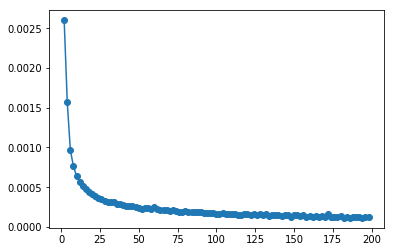

In [13]:
pd.Series(accum_personas).diff().plot(marker='o')

Alrededor de 20 usuarios estabilizan las palabras...

## Conclusión

Viendo que cerca de 40 palabras y 25 personas se remueven el 1% de las palabras, nos quedamos con eso. Me quedo con sólo el 5% de las palabras originales

In [26]:
words_left = df[(df.cant_palabra > 40) & (df.cant_usuarios > 25) ].shape[0] 
total = df.shape[0] 

print("Palabras no filtradas = {}".format(total))
print("Palabras filtradas = {}".format(words_left))
print("Queda el {:2.2f}% de las palabras".format(words_left * 100 / total))

Palabras no filtradas = 2330112
Palabras filtradas = 134898
Queda el 5.79% de las palabras
